In [59]:
# binder https://hub.gke.mybinder.org/user/blychs-climatologia_fisica-dckeuhha/notebooks/practica2.ipynb
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import xarray as xr
import metpy.calc as mpcalc
import datetime as dt
import calendar
import seaborn as sns
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [60]:
def load_mask(dataarray):
    """ Carga máscaras de tiempo de NDJFM y MJJAS"""
    mask_ndjfm = ((dataarray.time.dt.month == 11) + (dataarray.time.dt.month == 12) +
                        (dataarray.time.dt.month == 1) + (dataarray.time.dt.month == 2) +
                        (dataarray.time.dt.month == 3))
    mask_mjjas = ((dataarray.time.dt.month == 5) + (dataarray.time.dt.month == 6) +
                        (dataarray.time.dt.month == 7) + (dataarray.time.dt.month == 8) +
                        (dataarray.time.dt.month == 9))
    return mask_ndjfm, mask_mjjas


def set_monsoon_area(dataarray, method='IPCC', hemisphere='SH'):
    """
    Calcula el área monzónica. Devuelve el rango de precipitaciones en el monzón
    y una máscara que vale 1 donde hay monzón y cero donde no.""" 
    if method == 'IPCC':
        dataoutput = dataarray
        if hemisphere == 'SH':
            mask_lat = (dataarray.lat < 0)
            mask_summer = load_mask(dataoutput)[0]
            monthly_days_summer = 30.25
            mask_winter = load_mask(dataoutput)[1]
            monthly_days_winter = 30.6
        elif hemisphere == 'NH':
            mask_lat = (dataarray.lat > 0)
            mask_summer = load_mask(dataoutput)[1]
            monthly_days_summer = 30.6
            mask_winter = load_mask(dataoutput)[0]
            monthly_days_winter = 30.25
        difference = ((dataoutput.where(mask_summer).mean(dim='time') / monthly_days_summer)  - 
                       (dataoutput.where(mask_winter).mean(dim='time') / monthly_days_winter))
        monsoon_area = difference.where(mask_lat).where(difference > 2.5)
        mask_monsoon = monsoon_area.notnull()
        # GMP = xr.ones(mask_monsoon)
    # elif method == 'Hsu':
    #     if hemisphere
    return monsoon_area, mask_monsoon# , GMP


def ploteo_general(dataarray, title=None, vmin=None, vmax=None, projection=ccrs.PlateCarree(), figsize=(20,10),
                   extend='max'):
    plt.figure(figsize=(figsize))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ploteo = dataarray.plot(vmin=vmin, vmax=vmax, extend=extend, ax=ax)
    cmap = ploteo.get_cmap()
    cmap.set_under('w')
    ax.coastlines()
    plt.title(title)
    ax.add_feature(cfeature.BORDERS)
    return ax


In [127]:

def load_file(path):
    """
    Carga archivo/s y devuelve:
    Ensamble, ensamble en NDJFM, ensamble en MJJAS, media, media en NDJFM, media en MJJAS"""
    file_dict = {}
    ds = xr.open_mfdataset(path, combine='nested', concat_dim='ensemble').mean(dim='ensemble')
    file_dict['ds'] = ds
    file_dict['ndjfm'] = ds.where(load_mask(ds)[0])
    file_dict['mjjas'] = ds.where(load_mask(ds)[1])
    file_dict['mean'] = ds.mean(dim='time')
    file_dict['mean_ndjfm'] = file_dict['ndjfm'].mean(dim='time')
    file_dict['mean_mjjas'] = file_dict['mjjas'].mean(dim='time')
    return file_dict

def latlon_domain(dataset, lats_lons):
    """
    Aplica dominio de latitudes y longitudes a un xr.dataset.
    Debe recibir una lista con lon1, lon2, lat1, lat2"""
    dataoutput = dataset.loc[dict(lon=slice(lats_lons[0], lats_lons[1]),
                                  lat=slice(lats_lons[2], lats_lons[3]))]
    return dataoutput
    
def transform_lon(lon_values):
    return np.where(lon_values>=180, lon_values-360, lon_values)
    

In [63]:
# Open files
# pr_c5_hist = xr.open_mfdataset('NorESM1-M/pr_Amon_NorESM1-M_historical_*_197601-200512_2.5_mes.nc',
#                                 combine='nested', concat_dim='ensemble')
pr_obs = xr.open_dataset('observacionales/precip.mon.total.v7_197601-200512_2.5_anu.nc')
mask_land = 1 * np.ones((pr_obs.dims['lat'], pr_obs.dims['lon'])) * np.isfinite(pr_obs.precip.isel(time=0))
del pr_obs

pr_c5_hist = load_file('NorESM1-M/pr_Amon_NorESM1-M_historical_*_197601-200512_2.5_mes.nc')

pr_c5_26_close = load_file('NorESM1-M/pr_Amon_NorESM1-M_rcp26_r1i1p1_202001-204912_2.5_mes.nc')

pr_c5_85_close = load_file('NorESM1-M/pr_Amon_NorESM1-M_rcp85_r1i1p1_202001-204912_2.5_mes.nc')
pr_c5_26_far = load_file('NorESM1-M/pr_Amon_NorESM1-M_rcp26_r1i1p1_207001-209912_2.5_mes.nc')
pr_c5_85_far = load_file('NorESM1-M/pr_Amon_NorESM1-M_rcp85_r1i1p1_207001-209912_2.5_mes.nc')

pr_c6_hist = load_file('NorESM2-LM/pr_Amon_NorESM2-LM_historical_r*_2.5_mes.nc')
pr_c6_126_close = load_file('NorESM2-LM/pr_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5_mes.nc')
pr_c6_126_far = load_file('NorESM2-LM/pr_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5_mes.nc')
pr_c6_585_close = load_file('NorESM2-LM/pr_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5_mes.nc')
pr_c6_585_far = load_file('NorESM2-LM/pr_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5_mes.nc')


ua_c6_hist = load_file('NorESM2-LM/ua850_Amon_NorESM2-LM_historical_r*_2.5.nc')
ua_c6_126_close = load_file('NorESM2-LM/ua850_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5.nc')
ua_c6_126_far = load_file('NorESM2-LM/ua850_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5.nc')
ua_c6_585_close = load_file('NorESM2-LM/ua850_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5.nc')
ua_c6_585_far = load_file('NorESM2-LM/ua850_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5.nc')

va_c6_hist = load_file('NorESM2-LM/va850_Amon_NorESM2-LM_historical_r*_2.5.nc')
va_c6_126_close = load_file('NorESM2-LM/va850_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5.nc')
va_c6_126_far = load_file('NorESM2-LM/va850_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5.nc')
va_c6_585_close = load_file('NorESM2-LM/va850_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5.nc')
va_c6_585_far = load_file('NorESM2-LM/va850_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5.nc')

t_c5_hist = load_file('NorESM1-M/tas_Amon_NorESM1-M_historical_*_197601-200512_2.5_anu.nc')
t_c6_hist = load_file('NorESM2-LM/tas_Amon_NorESM2-LM_historical_r*_2.5.nc')
t_c5_26_close = load_file('NorESM1-M/tas_Amon_NorESM1-M_rcp26_r1i1p1_202001-204912_2.5_anu.nc')
t_c5_26_far = load_file('NorESM1-M/tas_Amon_NorESM1-M_rcp26_r1i1p1_207001-209912_2.5_anu.nc')
t_c5_85_close = load_file('NorESM1-M/tas_Amon_NorESM1-M_rcp85_r1i1p1_202001-204912_2.5_anu.nc')
t_c5_85_far = load_file('NorESM1-M/tas_Amon_NorESM1-M_rcp85_r1i1p1_207001-209912_2.5_anu.nc')
t_c6_126_close = load_file('NorESM2-LM/tas_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5.nc')
t_c6_126_far = load_file('NorESM2-LM/tas_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5.nc')
t_c6_585_close = load_file('NorESM2-LM/tas_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5.nc')
t_c6_585_far = load_file('NorESM2-LM/tas_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5.nc')

h_c5_hist = load_file('NorESM1-M/huss_Amon_NorESM1-M_historical_r*_197601-200512_2.5_anu.nc')
h_c6_hist = load_file('NorESM2-LM/huss_Amon_NorESM2-LM_historical_r*_2.5.nc')
h_c5_26_close = load_file('NorESM1-M/huss_Amon_NorESM1-M_rcp26_r1_202001-204912_2.5_anu.nc')
h_c5_26_far = load_file('NorESM1-M/huss_Amon_NorESM1-M_rcp26_r1_207001-209912_2.5_anu.nc')
h_c5_85_close = load_file('NorESM1-M/huss_Amon_NorESM1-M_rcp85_r1_202001-204912_2.5_anu.nc')
h_c5_85_far = load_file('NorESM1-M/huss_Amon_NorESM1-M_rcp85_r1_202001-204912_2.5_anu.nc')
h_c6_126_close = load_file('NorESM2-LM/huss_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5.nc')
h_c6_126_far = load_file('NorESM2-LM/huss_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5.nc')
h_c6_585_close = load_file('NorESM2-LM/huss_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5.nc')
h_c6_585_far = load_file('NorESM2-LM/huss_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5.nc')



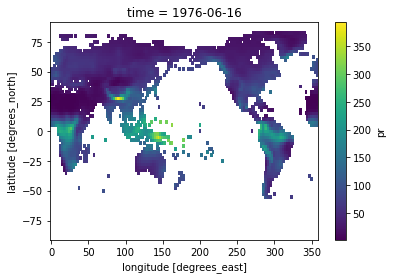

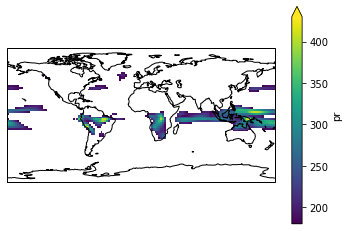

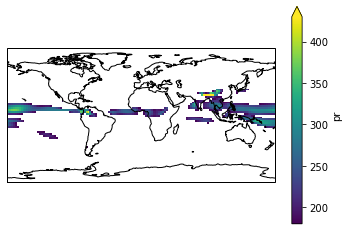

In [64]:
pr_c5_hist['mean'].where(mask_land == 1).pr.plot(); plt.show();
ax = plt.axes(projection=ccrs.PlateCarree());
pr_c5_hist['mean_ndjfm'].pr.plot(ax=ax, vmin=180, extend='max', vmax=430); ax.coastlines(); 
cmap=plt.get_cmap()
cmap.set_under('w')
plt.show();
ax = plt.axes(projection=ccrs.PlateCarree());
pr_c5_hist['mean_mjjas'].pr.plot(ax=ax, vmin=180, extend='max', vmax=430);
ax.coastlines();
plt.show();

In [23]:
# Create weights 
da = pr_c5_hist['ds'].pr
weights = np.cos(np.deg2rad(da.lat))
weights.name = "weights"

In [49]:
u_ndjfm_hist = ua_c6_hist['mean_ndjfm'].ua.isel(plev=0)
v_ndjfm_hist = va_c6_hist['mean_ndjfm'].va.isel(plev=0)
u_mjjas_hist = ua_c6_hist['mean_mjjas'].ua.isel(plev=0)
v_mjjas_hist = va_c6_hist['mean_mjjas'].va.isel(plev=0)

u_ndjfm_126_close = ua_c6_126_close['mean_ndjfm'].ua.isel(plev=0)
v_ndjfm_126_close = va_c6_126_close['mean_ndjfm'].va.isel(plev=0)
u_mjjas_126_close = ua_c6_126_close['mean_mjjas'].ua.isel(plev=0)
v_mjjas_126_close = va_c6_126_close['mean_mjjas'].va.isel(plev=0)

u_ndjfm_126_far = ua_c6_126_far['mean_ndjfm'].ua.isel(plev=0)
v_ndjfm_126_far = va_c6_126_far['mean_ndjfm'].va.isel(plev=0)
u_mjjas_126_far = ua_c6_126_far['mean_mjjas'].ua.isel(plev=0)
v_mjjas_126_far = va_c6_126_far['mean_mjjas'].va.isel(plev=0)

u_ndjfm_585_close = ua_c6_585_close['mean_ndjfm'].ua.isel(plev=0)
v_ndjfm_585_close = va_c6_585_close['mean_ndjfm'].va.isel(plev=0)
u_mjjas_585_close = ua_c6_585_close['mean_mjjas'].ua.isel(plev=0)
v_mjjas_585_close = va_c6_585_close['mean_mjjas'].va.isel(plev=0)

u_ndjfm_585_far = ua_c6_585_far['mean_ndjfm'].ua.isel(plev=0)
v_ndjfm_585_far = va_c6_585_far['mean_ndjfm'].va.isel(plev=0)
u_mjjas_585_far = ua_c6_585_far['mean_mjjas'].ua.isel(plev=0)
v_mjjas_585_far = va_c6_585_far['mean_mjjas'].va.isel(plev=0)

uvel_ndjfm_hist, lonu = add_cyclic_point(u_ndjfm, coord=u_ndjfm.lon)
vvel_ndjfm_hist, lonv = add_cyclic_point(v_ndjfm, coord=v_ndjfm.lon)
uvel_mjjas_hist, lonu = add_cyclic_point(u_mjjas, coord=u_mjjas.lon)
vvel_mjjas_hist, lonv = add_cyclic_point(v_mjjas, coord=v_mjjas.lon)
field, lon = add_cyclic_point(pr_c5_hist['mean'].pr, 
                              coord=pr_c5_hist['mean'].lon)
lonu = np.where(lonu>=180.,lonu-360.,lonu)

crs_latlon = ccrs.PlateCarree()


In [8]:
u1 = ua_c6_hist.mean(dim='ensemble').isel(plev=0)
u1.ua.where(load_mask(u1)[0])

<xarray.DataArray 'ua' (time: 360, lat: 73, lon: 144)>
dask.array<where, shape=(360, 73, 144), dtype=float32, chunksize=(360, 73, 144), chunktype=numpy.ndarray>
Coordinates:
    plev     float64 8.5e+04
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 1976-01-16 12:00:00 ... 2005-12-16 12:00:00
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0

542.2822897042446


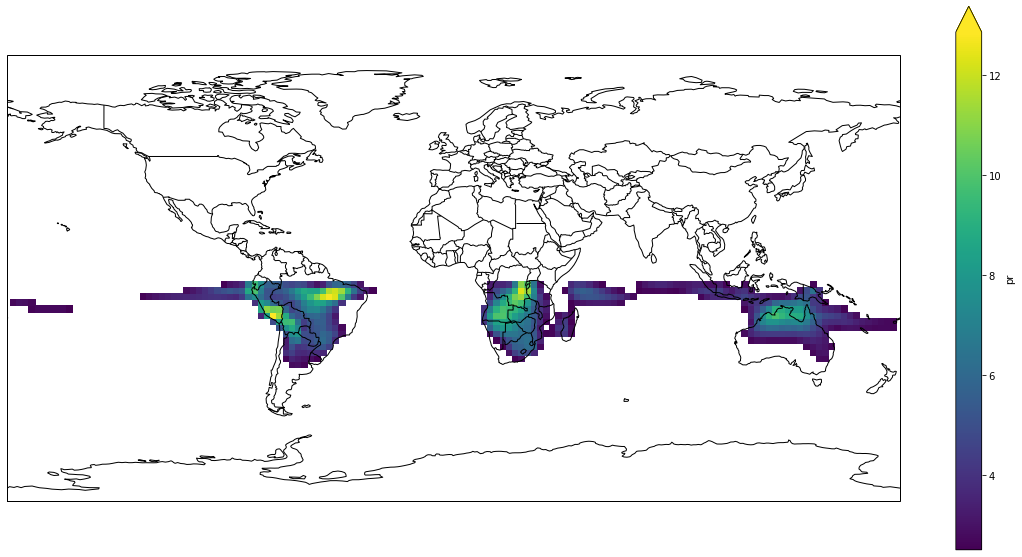

150.72693308054153


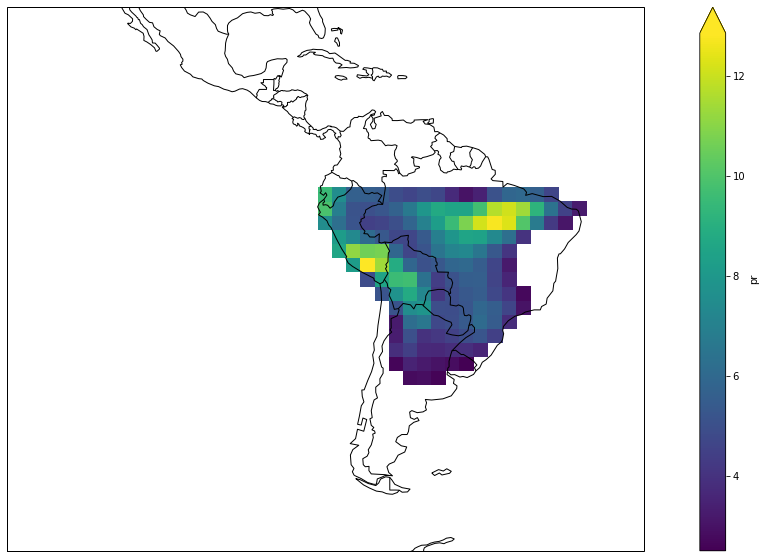

In [151]:
monsoon_land_sh, area_sh_hist = set_monsoon_area(pr_c5_hist['ds'].pr)
ploteo_general(monsoon_land_sh)
print((area_sh_hist * weights).sum().values )
plt.show()
print((latlon_domain(area_sh_hist, [230, 330, -60, 25]).where(mask_land == 1) * weights).sum().values )
ploteo_general(latlon_domain(monsoon_land_sh, [230, 330, -60, 25]).where(mask_land == 1))


In [120]:


##################################
monsoon_sh_hist, area_sh_hist = set_monsoon_area(pr_c5_hist['ds'].pr) 
monsoon_nh_hist, area_nh_hist = set_monsoon_area(pr_c5_hist['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_sh_hist.combine_first(monsoon_nh_hist), vmax=10,
               title='NorESM1-M, rango de precipitaciones (mm día$^{-1}$)')
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
print('N° celdas histórico ')
print(((area_nh_hist + area_sh_hist) * weights).sum().values)
plt.show()

####
monsoon_sh_hist, area_sh_hist = set_monsoon_area(pr_c5_hist['ds'].pr)
monsoon_nh_hist, area_nh_hist = set_monsoon_area(pr_c5_hist['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_sh_hist.combine_first(monsoon_nh_hist), vmax=10,
               title='NorESM1-M, rango de precipitaciones (mm día$^{-1}, MJJAS$)')
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
print('N° celdas histórico ')
print(((area_nh_hist + area_sh_hist)* weights).sum().values)
plt.show()

####

monsoon_sh_26_close, area_sh_26_close = set_monsoon_area(pr_c5_26_close['ds'].pr)
monsoon_nh_26_close, area_nh_26_close = set_monsoon_area(pr_c5_26_close['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_sh_26_close.combine_first(monsoon_nh_26_close), vmax = 10,
               title='NorESM1-M - RCP26, 2020-2050, rango de ppnes (mm días$^{-1}$)')
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
print('N° celdas RCP 26:')
print(((area_nh_26_close + area_sh_26_close)* weights).sum().values)
plt.show()

#####

monsoon_sh_85_close, area_sh_85_close = set_monsoon_area(pr_c5_85_close['ds'].pr)
monsoon_nh_85_close, area_nh_85_close = set_monsoon_area(pr_c5_85_close['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_sh_85_close.combine_first(monsoon_nh_85_close), vmax = 10,
               title='NorESM1-M - RCP85, 2020-2050, rango de ppnes (mm días$^{-1}$)')
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
print('N° celdas RCP 85:')
print(((area_nh_85_close + area_sh_85_close)* weights).sum().values)
plt.show()

#####

monsoon_sh_26_far, area_sh_26_far = set_monsoon_area(pr_c5_26_far['ds'].pr)
monsoon_nh_26_far, area_nh_26_far = set_monsoon_area(pr_c5_26_far['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_sh_26_far.combine_first(monsoon_nh_26_far), vmax = 10,
               title='NorESM1-M - RCP26, 2070-2100, rango de ppnes (mm días$^{-1}$)')
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
print('N° celdas RCP 26:')
print(((area_nh_26_far + area_sh_26_far)* weights).sum().values)
plt.show()

#####

monsoon_sh_85_far, area_sh_85_far = set_monsoon_area(pr_c5_85_far['ds'].pr)
monsoon_nh_85_far, area_nh_85_far = set_monsoon_area(pr_c5_85_far['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_sh_85_far.combine_first(monsoon_nh_85_far), vmax = 10,
               title='NorESM1-M - RCP26, 2070-2100, rango de ppnes (mm días$^{-1}$)')
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
print('N° celdas RCP 85:')
print(((area_nh_85_far + area_sh_85_far)* weights).sum().values)
plt.show()

##################
ax = ploteo_general(pr_c5_85_far['ds'].pr.where(load_mask(pr_c5_85_far['ds'])[0]).mean(dim='time').where(
                    area_sh_85_far + area_nh_85_far == 1) - pr_c5_26_far['ds'].pr.mean(dim='time'))
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
plt.show()

ax = ploteo_general(pr_c5_85_far['ds'].pr.where(load_mask(pr_c5_85_far['ds'])[1]).mean(dim='time').where(area_sh_85_far + area_nh_85_far == 1) - 
                    pr_c5_26_far['ds'].pr.mean(dim='time'))
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)

AttributeError: 'NoneType' object has no attribute 'lat'

N° celdas histórico 
1347


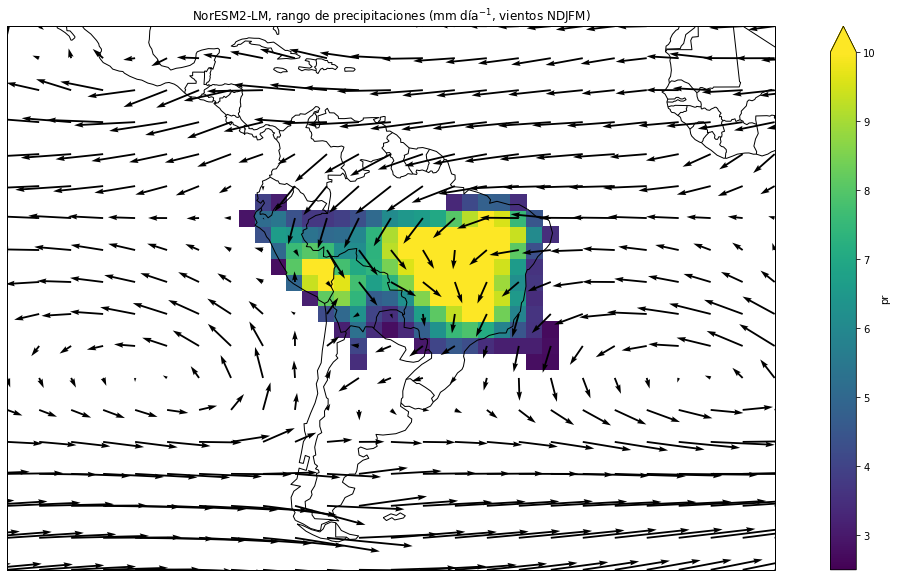

N° celdas histórico 
1347


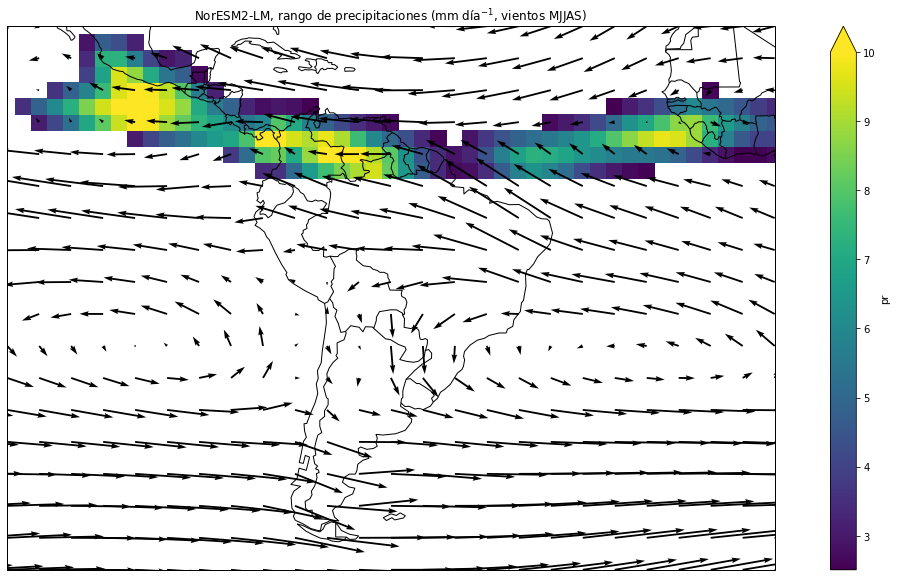

N° celdas SSPS 126:
1324


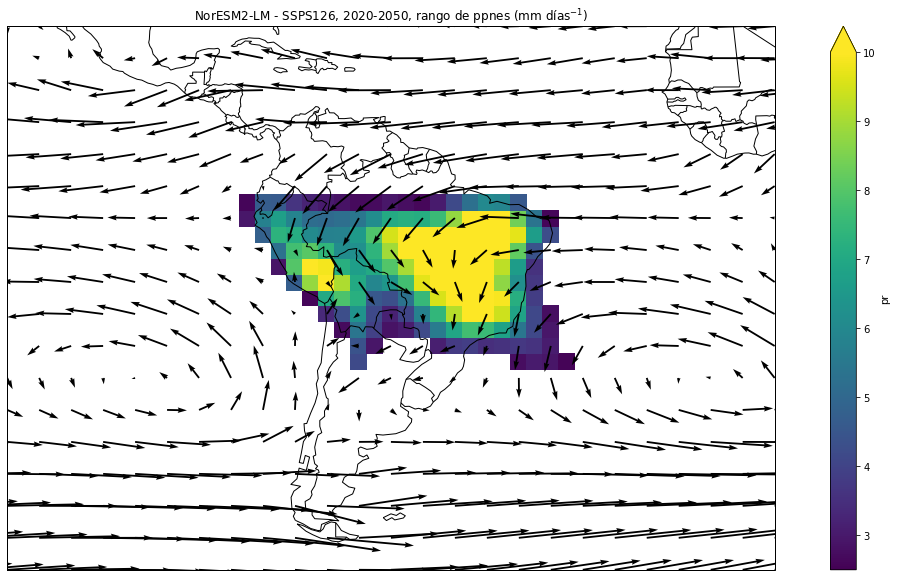

N° celdas SSPS 126:
1306


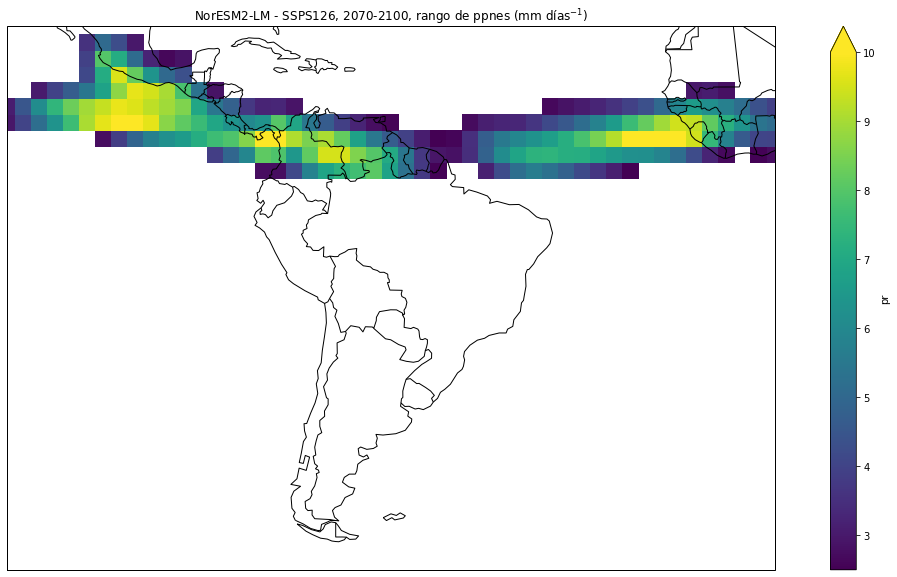

N° celdas SSPS 585:
1309


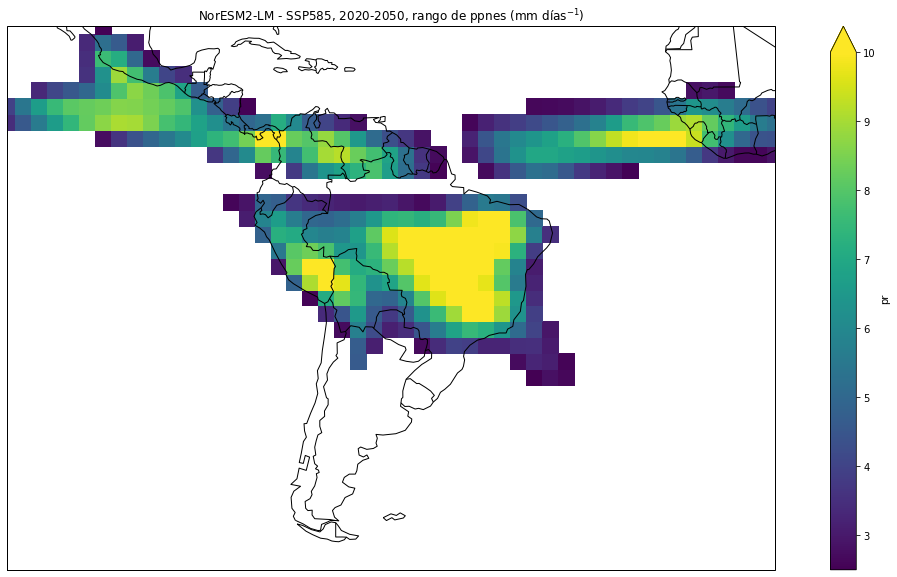

N° celdas SSPS 585:
1314


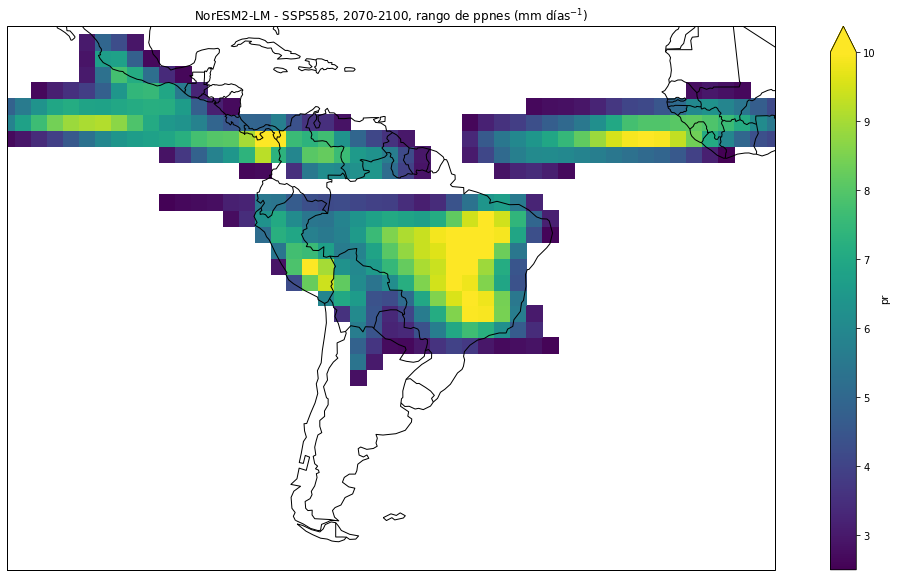

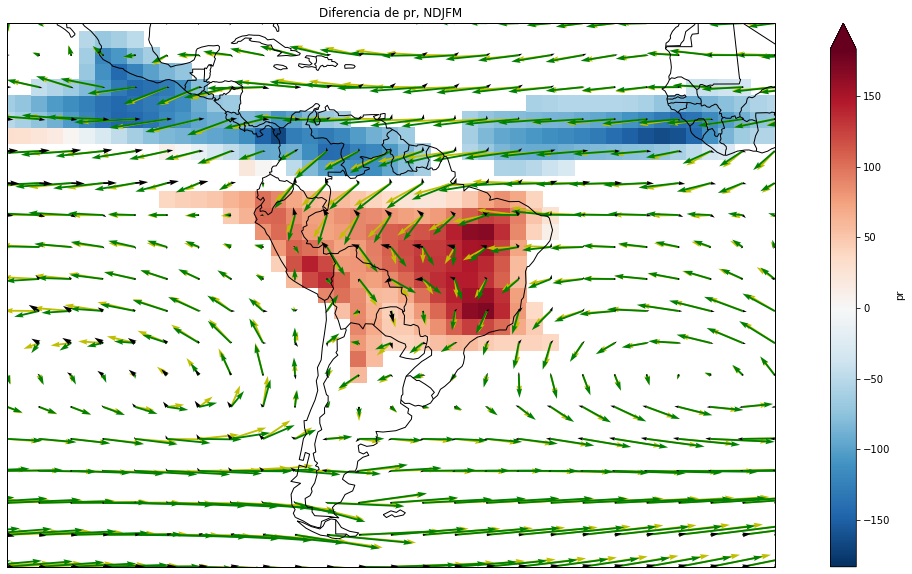

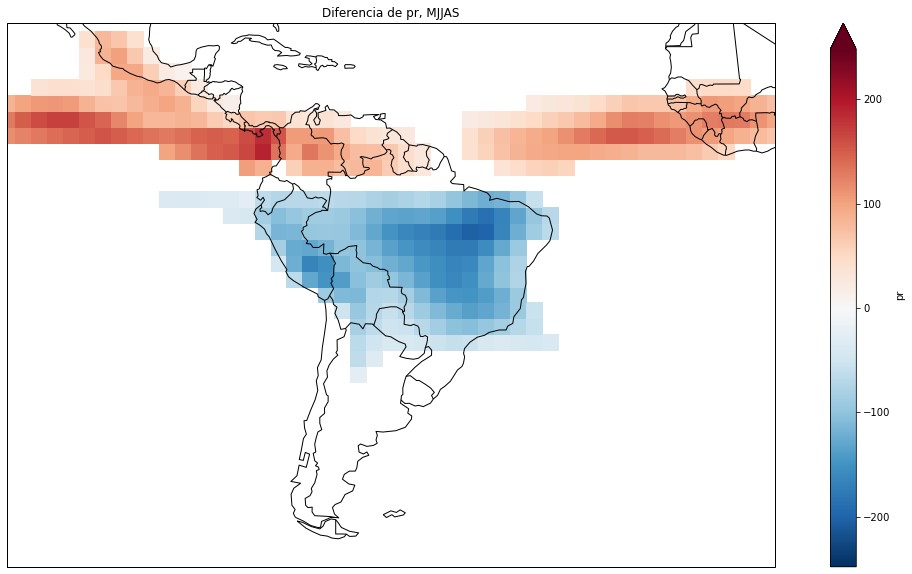

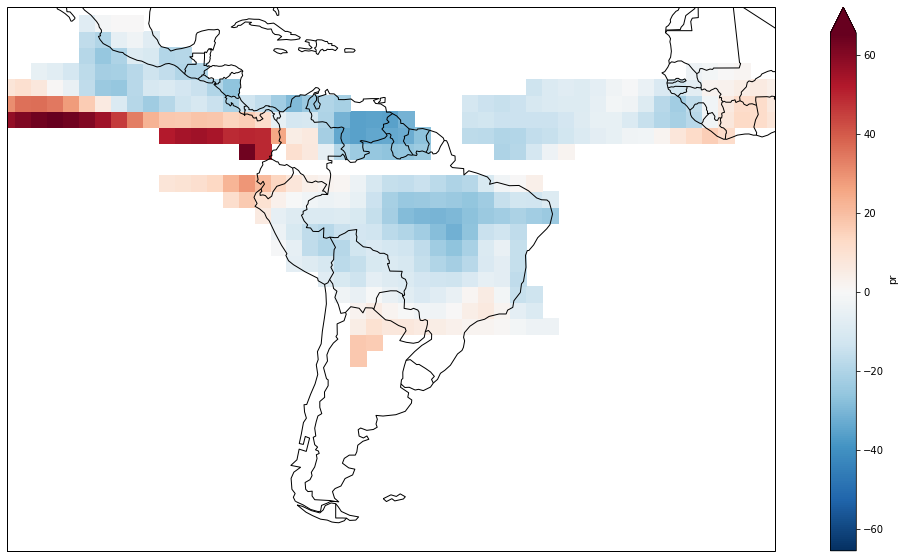

In [102]:
monsoon_sh_hist, area_sh_hist = set_monsoon_area(pr_c6_hist['ds'].pr) 
monsoon_nh_hist, area_nh_hist = set_monsoon_area(pr_c6_hist['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_sh_hist, vmax=10,
               title='NorESM2-LM, rango de precipitaciones (mm día$^{-1}$, vientos NDJFM)')
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
ax.quiver(u_ndjfm_hist.lon[0::2], u_ndjfm_hist.lat[0::2], u_ndjfm_hist[0::2, 0::2],
                                            v_ndjfm_hist[0::2, 0::2], scale=130)
print('N° celdas histórico ')
print((area_nh_hist + area_sh_hist).sum().values)
plt.show()

# """"""""""""""""""""""""""""""""""""""""""""""""""
# monsoon_sh_hist, area_sh_hist = set_monsoon_area(pr_c6_hist['ds'].pr) 
# monsoon_nh_hist, area_nh_hist = set_monsoon_area(pr_c6_hist['ds'].pr, hemisphere='NH')
# ax = ploteo_general(monsoon_sh_hist.combine_first(monsoon_nh_hist), vmax=10,
#                title='NorESM2-LM, rango de precipitaciones (mm día$^{-1}$, vientos NDJFM)')
# ax.set_extent([-180, 20, -60, 70], crs=crs_latlon)
# ax.streamplot(lonu, u_ndjfm.lat, uvel_ndjfm, vvel_ndjfm, color='b')
# print('N° celdas histórico ')
# print((area_nh_hist + area_sh_hist).sum().values)
# plt.show()
# """"""""""""""""""""""""""""""""""""""""""""""""""
monsoon_sh_hist, area_sh_hist = set_monsoon_area(pr_c6_hist['ds'].pr)
monsoon_nh_hist, area_nh_hist = set_monsoon_area(pr_c6_hist['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_nh_hist, vmax=10,
               title='NorESM2-LM, rango de precipitaciones (mm día$^{-1}$, vientos MJJAS)')
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
ax.quiver(u_mjjas_hist.lon[0::2], u_mjjas_hist.lat[0::2], u_mjjas_hist[0::2, 0::2],
                                            v_mjjas_hist[0::2, 0::2], scale=130)
print('N° celdas histórico ')
print((area_nh_hist + area_sh_hist).sum().values)
plt.show()

# """"""""""""""""""""""""""""""""""""""""""""""""""
# monsoon_sh_hist, area_sh_hist = set_monsoon_area(pr_c6_hist['ds'].pr)
# monsoon_nh_hist, area_nh_hist = set_monsoon_area(pr_c6_hist['ds'].pr, hemisphere='NH')
# ax = ploteo_general(monsoon_sh_hist.combine_first(monsoon_nh_hist), vmax=10,
#                title='NorESM2-LM, rango de precipitaciones (mm día$^{-1}$, vientos MJJAS)')
# ax.set_extent([-180, 0, -60, 70], crs=crs_latlon)
# ax.streamplot(lonu, u_mjjas.lat, uvel_mjjas, vvel_mjjas, color='b', density=1)
# #ax.streamplot(lonu, u.lat, uvel_mjjas.mean(axis=0), vvel_mjjas.mean(axis=0), color='r')
# print('N° celdas histórico ')
# print((area_nh_hist + area_sh_hist).sum().values)
# plt.show()
# 
# """"""""""""""""""""""""""""""""""""""""""""""""""

monsoon_sh_126_close, area_sh_126_close = set_monsoon_area(pr_c6_126_close['ds'].pr)
monsoon_nh_126_close, area_nh_126_close = set_monsoon_area(pr_c6_126_close['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_sh_126_close, vmax = 10,
                    title='NorESM2-LM - SSPS126, 2020-2050, rango de ppnes (mm días$^{-1}$)')
ax.quiver(u_ndjfm_126_close.lon[0::2], u_ndjfm_126_close.lat[0::2],
          u_ndjfm_126_close[0::2, 0::2], v_ndjfm_126_close[0::2, 0::2], scale=130)
print('N° celdas SSPS 126:')
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
print((area_nh_126_close + area_sh_126_close).sum().values)
plt.show()

#####

#####

monsoon_sh_126_far, area_sh_126_far = set_monsoon_area(pr_c6_126_far['ds'].pr)
monsoon_nh_126_far, area_nh_126_far = set_monsoon_area(pr_c6_126_far['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_nh_126_far, vmax = 10,
                    title='NorESM2-LM - SSPS126, 2070-2100, rango de ppnes (mm días$^{-1}$)')
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
print('N° celdas SSPS 126:')
print((area_nh_126_far + area_sh_126_far).sum().values)
plt.show()

#####

monsoon_sh_585_close, area_sh_585_close = set_monsoon_area(pr_c6_585_close['ds'].pr)
monsoon_nh_585_close, area_nh_585_close = set_monsoon_area(pr_c6_585_close['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_sh_585_close.combine_first(monsoon_nh_585_close), vmax = 10,
                    title='NorESM2-LM - SSP585, 2020-2050, rango de ppnes (mm días$^{-1}$)')
print('N° celdas SSPS 585:')
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
print((area_nh_585_close + area_sh_585_close).sum().values)
plt.show()

#####

#####

monsoon_sh_585_far, area_sh_585_far = set_monsoon_area(pr_c6_585_far['ds'].pr)
monsoon_nh_585_far, area_nh_585_far = set_monsoon_area(pr_c6_585_far['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_sh_585_far.combine_first(monsoon_nh_585_far), vmax = 10,
                    title='NorESM2-LM - SSPS585, 2070-2100, rango de ppnes (mm días$^{-1}$)')
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
print('N° celdas SSPS 585:')
print((area_nh_585_far + area_sh_585_far).sum().values)
plt.show()

##########

ax = ploteo_general(pr_c6_585_far['ds'].pr.where(load_mask(pr_c6_585_far['ds'])[0]
                                          ).mean(dim='time').where(area_sh_585_far + 
                                                                   area_nh_585_far == 1) - 
                    pr_c6_126_far['ds'].pr.mean(dim='time'), title='Diferencia de pr, NDJFM')

ax.quiver(u_ndjfm_585_far.lon[0::2], u_ndjfm_585_far.lat[0::2],
          u_ndjfm_585_far[0::2, 0::2], v_ndjfm_585_far[0::2, 0::2], color='y', scale=130)

ax.quiver(u_ndjfm_hist.lon[0::2], u_ndjfm_hist.lat[0::2],
          u_ndjfm_hist[0::2, 0::2], v_ndjfm_hist[0::2, 0::2], color='g', scale=130)

ax.quiver(u_ndjfm_585_far.lon[0::2], u_ndjfm_585_far.lat[0::2],
          u_ndjfm_585_far[0::2, 0::2] - u_ndjfm_hist[0::2, 0::2],
          v_ndjfm_585_far[0::2, 0::2] - v_ndjfm_hist[0::2, 0::2], color='k', scale=130)
#ax.streamplot(transform_lon(u_ndjfm_585_far.lon.values), u_ndjfm_585_far.lat.values,
#              u_ndjfm_585_far.values, v_ndjfm_585_far.values, density=3)
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
plt.show()

ax = ploteo_general(pr_c6_585_far['ds'].pr.where(load_mask(pr_c6_585_far['ds'])[1]
                                          ).mean(dim='time').where(area_sh_585_far +
                                                                   area_nh_585_far == 1) - 
                    pr_c6_126_far['ds'].pr.mean(dim='time'), title='Diferencia de pr, MJJAS')

ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)
plt.show()

ax = ploteo_general(pr_c6_585_far['ds'].pr.mean(dim='time').where(area_sh_585_far + area_nh_585_far == 1) - 
                    pr_c6_126_far['ds'].pr.mean(dim='time'))
ax.set_extent([-120, 0, -60, 25], crs=crs_latlon)

N° celdas histórico 
1347


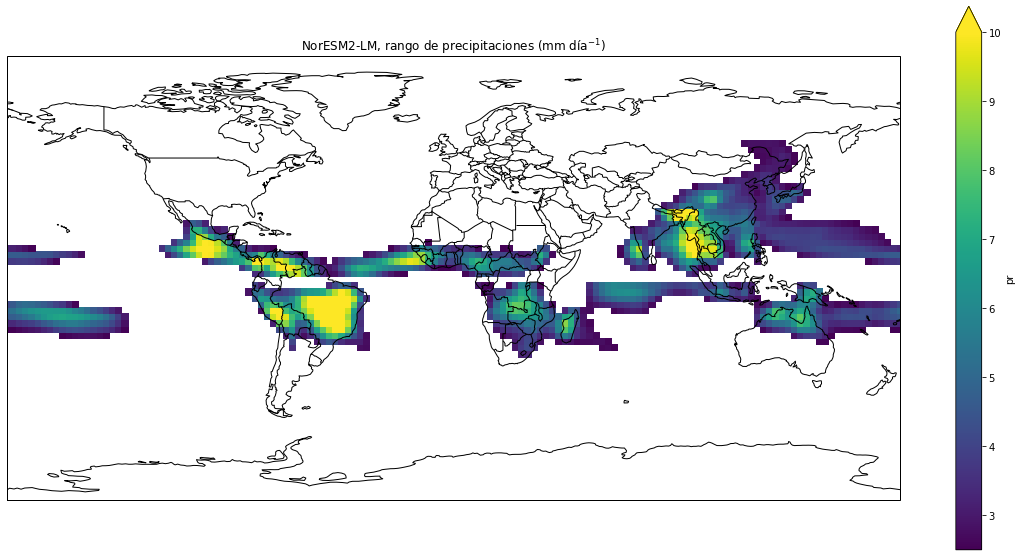

N° celdas SSPS 126:
1324


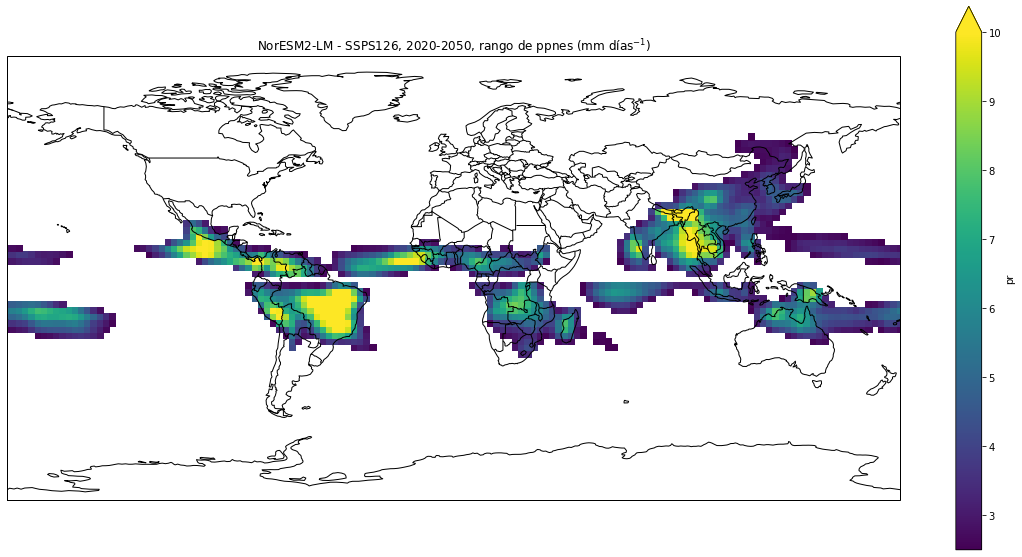

N° celdas SSPS 126:
1306


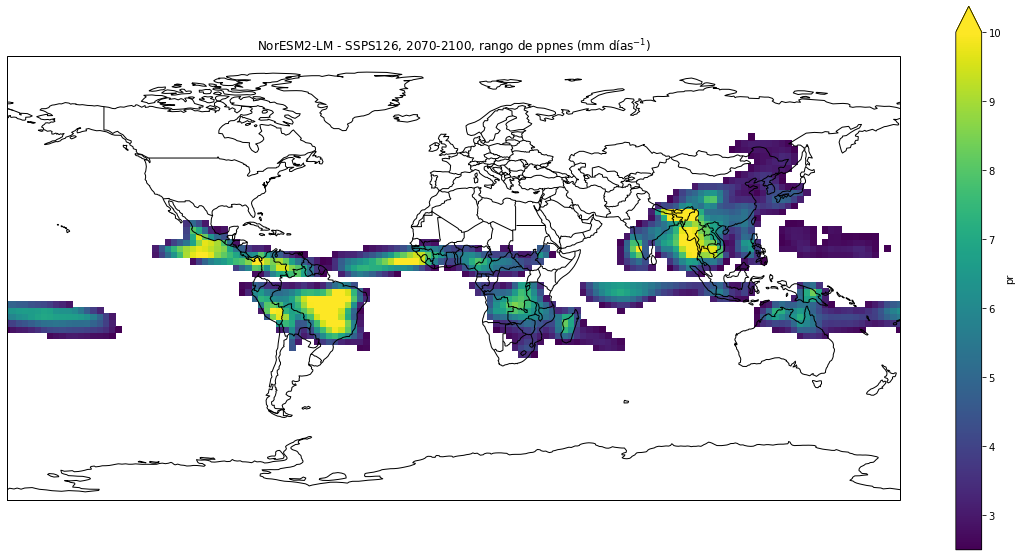

In [40]:
monsoon_sh_hist, area_sh_hist = set_monsoon_area(pr_c6_hist['ds'].pr)
monsoon_nh_hist, area_nh_hist = set_monsoon_area(pr_c6_hist['ds'].pr, hemisphere='NH')
ax = ploteo_general(monsoon_sh_hist.combine_first(monsoon_nh_hist), vmax=10,
                             title='NorESM2-LM, rango de precipitaciones (mm día$^{-1}$)')
print('N° celdas histórico ')
print((area_nh_hist + area_sh_hist).sum().values)
plt.show()

####

monsoon_sh_126_close, area_sh_126_close = set_monsoon_area(pr_c6_126_close['ds'].pr)
monsoon_nh_126_close, area_nh_126_close = set_monsoon_area(pr_c6_126_close['ds'].pr, hemisphere='NH')
ploteo_general(monsoon_sh_126_close.combine_first(monsoon_nh_126_close), vmax = 10,
               title='NorESM2-LM - SSPS126, 2020-2050, rango de ppnes (mm días$^{-1}$)')
print('N° celdas SSPS 126:')
print((area_nh_126_close + area_sh_126_close).sum().values)
plt.show()

#####


#####

monsoon_sh_126_far, area_sh_126_far = set_monsoon_area(pr_c6_126_far['ds'].pr)
monsoon_nh_126_far, area_nh_126_far = set_monsoon_area(pr_c6_126_far['ds'].pr, hemisphere='NH')
ploteo_general(monsoon_sh_126_far.combine_first(monsoon_nh_126_far), vmax = 10,
               title='NorESM2-LM - SSPS126, 2070-2100, rango de ppnes (mm días$^{-1}$)')
print('N° celdas SSPS 126:')
print((area_nh_126_far + area_sh_126_far).sum().values)
plt.show()

#####


In [12]:
# ########### Con rolling average
# average_c5_hist =  pr_c5_hist.pr.mean(dim='ensemble').rolling(time=5)
# average_c5_hist = average_c5_hist.reduce(np.std)
# plt.figure(figsize=(20,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# difference_NH = ((average_c5_hist.where(average_c5_hist.time.dt.month == 7)/153).mean(dim='time') - (
#                  (average_c5_hist.where(average_c5_hist.time.dt.month == 1)/151).mean(dim='time')))
# difference_NH.plot(axes = ax, vmin=1, vmax=3)
# ax.coastlines()
# ax.add_feature(cfeature.BORDERS)
# 

<xarray.DataArray 'time' (time: 360)>
array([cftime.DatetimeNoLeap(1976-01-16 12:00:00),
       cftime.DatetimeNoLeap(1976-02-15 00:00:00),
       cftime.DatetimeNoLeap(1976-03-16 12:00:00), ...,
       cftime.DatetimeNoLeap(2005-10-16 12:00:00),
       cftime.DatetimeNoLeap(2005-11-16 00:00:00),
       cftime.DatetimeNoLeap(2005-12-16 12:00:00)], dtype=object)
Coordinates:
  * time     (time) object 1976-01-16 12:00:00 ... 2005-12-16 12:00:00
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T


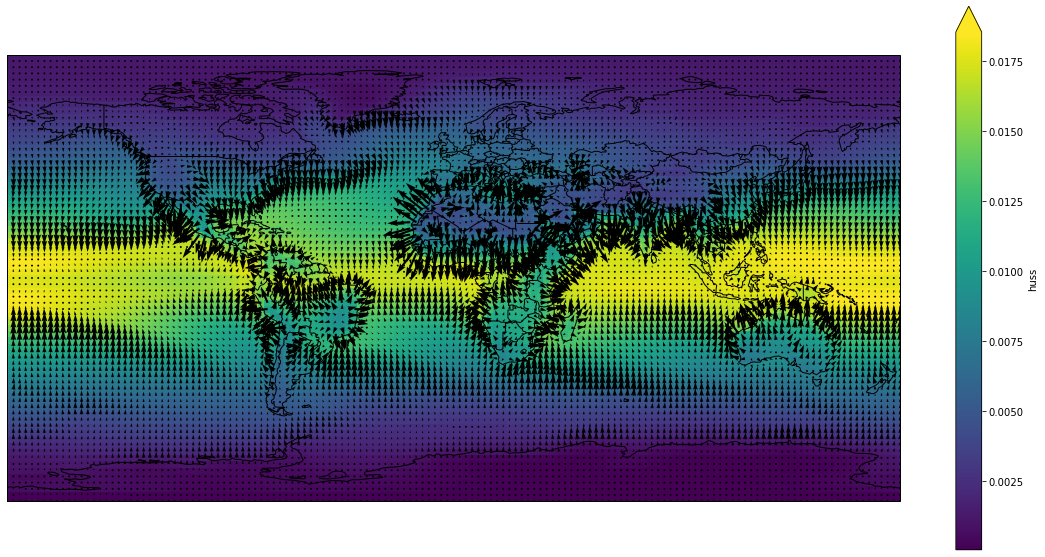

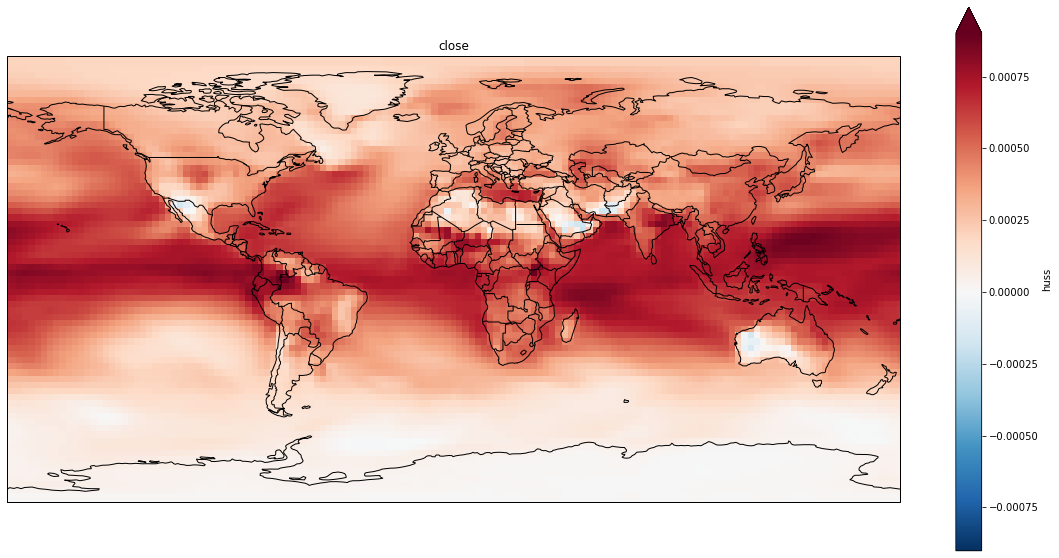

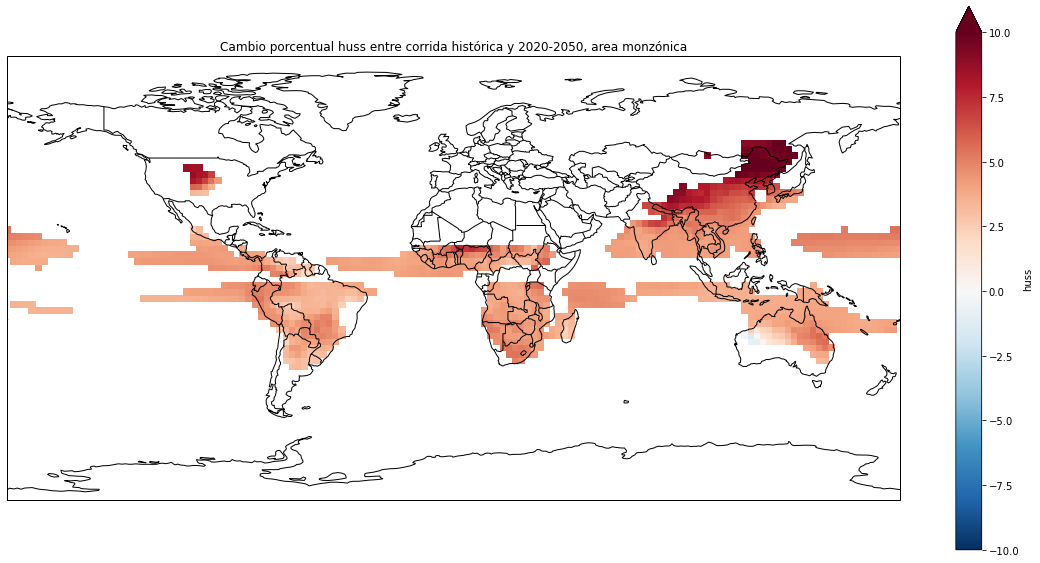

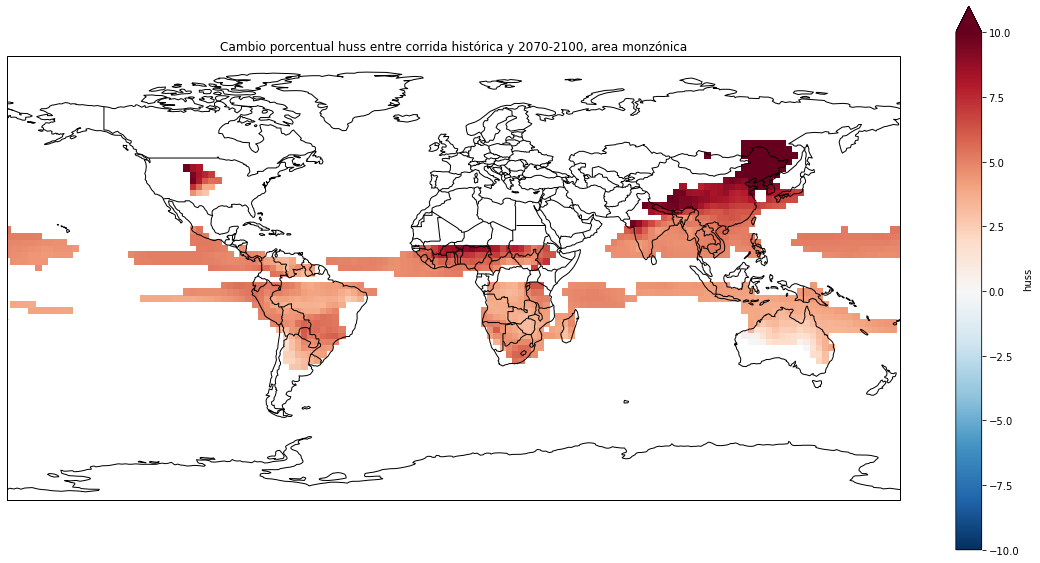

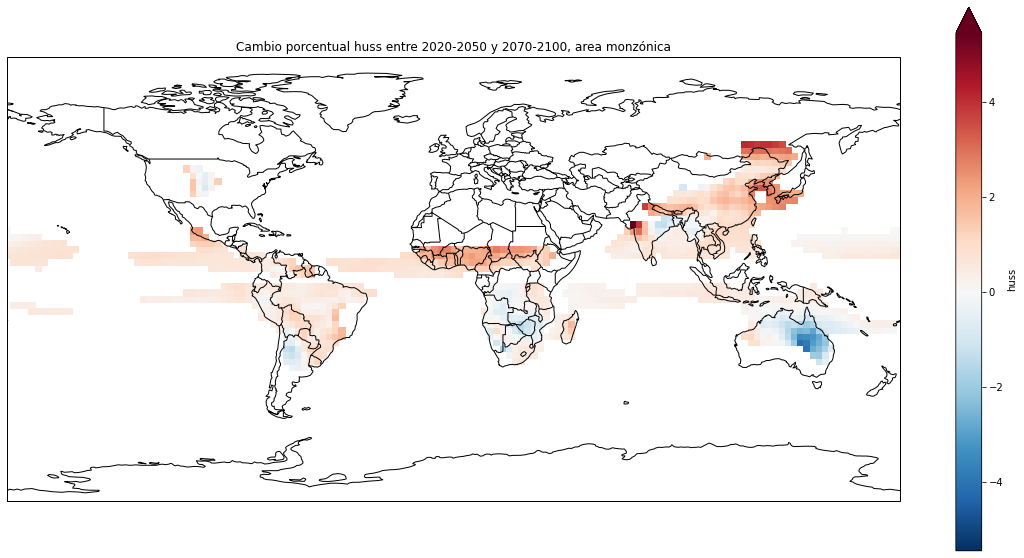

In [184]:
########### Comparando humedad del suelo
print(h_c5_hist['ds'].time)
h5_hist = h_c5_hist['mean'].huss
dq_dx = (h_c5_hist['mean'].huss * 2264.7).differentiate(coord='lon')
dq_dy = (h_c5_hist['mean'].huss * 2264.7).differentiate(coord='lat')
ax = ploteo_general(h5_hist);
ax.quiver(h_c5_hist['mean'].lon, h_c5_hist['mean'].lat, dq_dx, dq_dy)
plt.show()
ploteo_general(h_c5_26_close['mean'].huss - h5_hist, title='close');
plt.show()
ploteo_general(200 * (h_c5_26_close['mean'].huss.where((area_sh_hist + area_nh_hist) == 1) -
                      h5_hist.where(area_nh_hist + area_sh_hist == 1))/
               (h_c5_26_close['mean'].huss + h5_hist), vmax=10,
              title='Cambio porcentual huss entre corrida histórica y 2020-2050, area monzónica')
plt.show()
ploteo_general(200 * (h_c5_26_far['mean'].huss.where((area_sh_hist + area_nh_hist) == 1) -
                      h5_hist.where(area_nh_hist + area_sh_hist == 1))/
               (h_c5_26_far['mean'].huss + h5_hist), vmax=10,
              title='Cambio porcentual huss entre corrida histórica y 2070-2100, area monzónica')
plt.show()
ploteo_general(200 * (h_c5_26_far['mean'].huss.where((area_sh_hist + area_nh_hist) == 1) -
                      h_c5_26_close['mean'].huss.where(area_nh_hist + area_sh_hist == 1))/
               (h_c5_26_far['mean'].huss + h_c5_26_close['mean'].huss),
              title='Cambio porcentual huss entre 2020-2050 y 2070-2100, area monzónica')
plt.show()

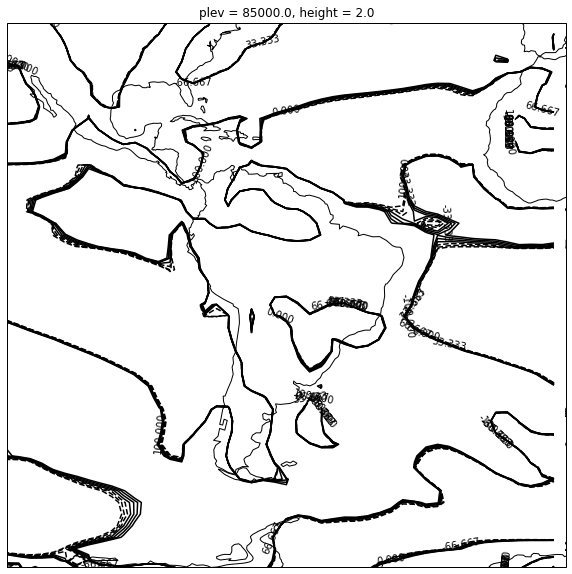

In [223]:
#plt.show();
dT_dx = t_c6_hist['mean_ndjfm'].tas.differentiate(coord='lon')
dT_dy = t_c6_hist['mean_ndjfm'].tas.differentiate(coord='lat')

adv_h = -(u_ndjfm  * ((dT_dx + dq_dx) * 1000) + v_ndjfm * ((dT_dy + dq_dy) * 1000))

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-1200, 0, -60, 25])
ploteo = adv_h.plot.contour(ax=ax, vmax=100, vmin=None, colors='k')
plt.clabel(ploteo, inline=1, fontsize=10)
ax.coastlines()
